# 电商页面A/B测试

## 背景
某电商公司非常重视自己的落地页设计，希望通过改进设计来提高转化率。
往年的平均转化率为13%，现在希望提高到15%。
在正式推出新页面之前，该公司决定通过A/B测试在小范围的用户中进行测试，以保证达到预期效果。

## 实验流程
### 1.实验改动点确定
本项目的实验变量为落地页的不同设计风格。

### 2.确定实验目标和衡量指标
目标：通过AB测试确定新页面设计能否提高2%的转化率

衡量指标：转化率

### 3.提出假设
H0:P0=P1
H1:P0≠P1
P0为旧版页面设计的转化率，P1为新版页面设计的转化率

### 4.实验分组
遵循随机化原则，实验组和对照组在性别、年龄、地域、活跃程度等关键特征上尽可能一致。

- 对照组：用户看到旧版的落地页
- 实验组：用户看到新版的落地页

为便于计算转化率，对用户购买行为进行记录：
0：用户在测试期间没有购买产品
1：用户在测试期间购买了产品
通过求平均值，得到每个组的转化率

### 5.计算实验最小样本量和实验周期
设置：
α=0.05
1-β=0.8
根据最小样本量计算公式，得出本实验的最小样本量为N=4720
总样本量为2N=9440

该落地页以往每天的平均浏览人数为1000，则实验周期至少需要的天数
9440/1000=9.44，约10天

### 6.进行灰度测试
正式开始AB测试之前，为了确保实验改动不会对系统和用户体验产生巨大的异常影响，需要先选取一小部分用户进行灰度测试，评估实验改动点的风险和稳定性。

### 7.AB测试上线和数据收集
根据确定好的实验方案，正式进行AB测试，记录核心指标，进行后续分析

### 8.数据分析及假设检验
这里使用Kaggle上的电商页面AB测试数据集

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms

In [71]:
# 导入数据集
data = pd.read_csv('./data/ab_data.csv')
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


user_id:用户的id

timestamp:用户访问页面的时间

group:用户属于 哪个组（control为对照组，treatment为实验组）

landing_page:用户访问的是旧版落地页 还是新版落地页

converted:是否成功转化（0代表未转化，1代表转化）

In [72]:
# 查看数据的整体信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [73]:
# 数据清洗

# 检查缺失值
data.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [74]:
# 重复值处理
data.duplicated().sum()

0

In [75]:
# 用户id是否重复
data['user_id'].duplicated().sum()

3894

In [76]:
# 删除这些重复用户
repeat_id = data[data["user_id"].duplicated()]["user_id"]
data_new = data[~data["user_id"].isin(repeat_id)]

In [77]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286690 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       286690 non-null  int64 
 1   timestamp     286690 non-null  object
 2   group         286690 non-null  object
 3   landing_page  286690 non-null  object
 4   converted     286690 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.1+ MB


In [78]:
data_new["user_id"].duplicated().sum()

0

In [79]:
# 查找分组和落地页不匹配的数据

# group和landing_page交叉统计，查看是否一一匹配
pd.crosstab(data_new["group"], data_new["landing_page"])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


In [80]:
# 查看总共统计天数
date_days=pd.to_datetime(data["timestamp"]).dt.strftime("%Y-%m-%d")
len(date_days.unique())

23

满足之前的实验周期>10的要求

In [94]:
# 根据最小样本量4720抽样，这里每组抽取5000条样本
required_n = 5000
control_sample = data_new[data_new["group"] == 'control'].sample(n=required_n)
treatment_sample = data_new[data_new["group"] == 'treatment'].sample(n=required_n)
test_data = pd.concat([control_sample,treatment_sample], ignore_index=True)
test_data

,user_id,timestamp,group,landing_page,converted
0,855720,2017-01-10 22:21:54.350166,control,old_page,0
1,713261,2017-01-12 10:00:09.754866,control,old_page,0
2,858515,2017-01-08 13:33:56.957089,control,old_page,0
3,684475,2017-01-21 20:15:47.258798,control,old_page,0
4,631569,2017-01-06 00:19:00.312281,control,old_page,0
...,...,...,...,...,...
9995,790439,2017-01-21 03:41:24.576336,treatment,new_page,0
9996,882545,2017-01-20 05:22:45.265753,treatment,new_page,1
9997,665022,2017-01-17 11:17:32.551769,treatment,new_page,0
9998,820147,2017-01-19 12:21:56.333801,treatment,new_page,0


In [96]:
# 进行可视化分析
conversion_rates = test_data.groupby("group")["converted"].agg(['mean', 'std'])
conversion_rates.rename(columns={'mean': 'conversion_rate', 'std': 'std_deviation'}, inplace=True)
conversion_rates

,conversion_rate,std_deviation
group,,
control,0.1266,0.332558
treatment,0.1230,0.328470


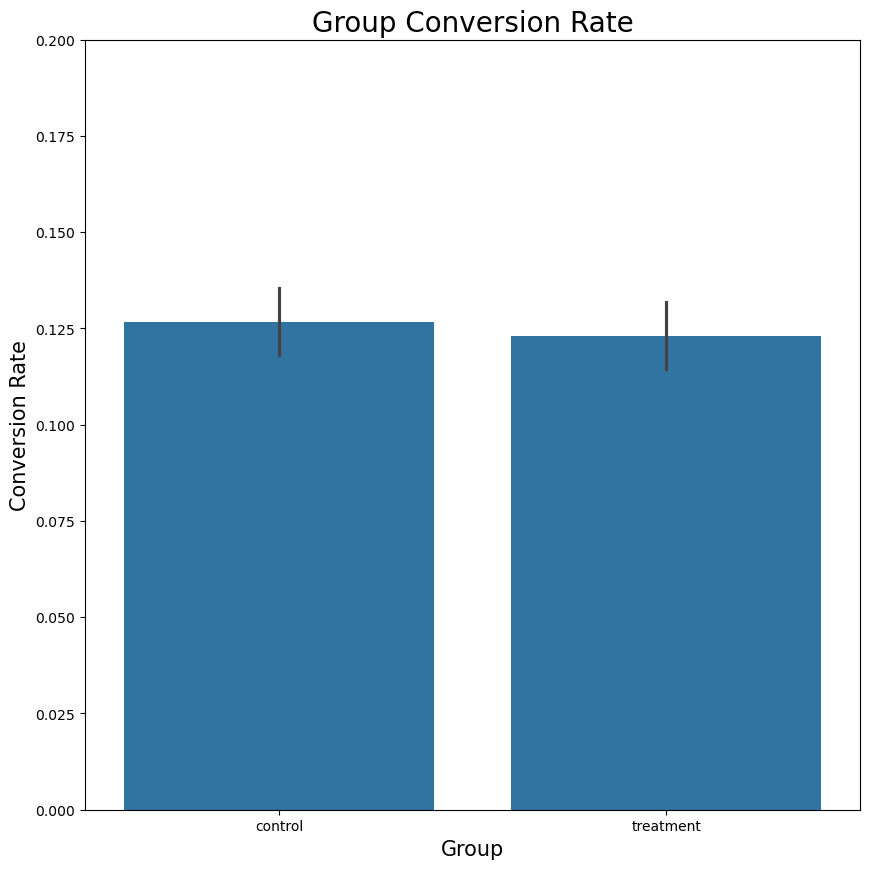

In [97]:
plt.figure(figsize = (10,10), dpi = 100)

sns.barplot(x=test_data['group'], y=test_data['converted'])

plt.ylim(0, 0.2)
plt.title('Group Conversion Rate', fontsize=20)
plt.xlabel('Group', fontsize=15)
plt.ylabel('Conversion Rate', fontsize=15)
plt.show()

新旧两版落地页的转化率较为接近，实验组的转化率相比降低了0.0036

接下来进行假设检验
构造z统计量，计算p值和置信区间

In [101]:
from statsmodels.stats.proportion import proportions_ztest,proportion_confint

control_results = test_data[test_data["group"] == 'control']["converted"]
treatment_results = test_data[test_data["group"] == 'treatment']["converted"]

n_con = control_results.count()
n_treat = treatment_results.count()
nobs = [n_con,n_treat]
successes = [ treatment_results.sum(), control_results.sum()]
print(nobs, successes)

[5000, 5000] [615, 633]


In [103]:
# 计算z值和p值
z_stat, p = proportions_ztest(successes, nobs)

# 计算临界值
critical_value = stats.norm.ppf(1-0.025)

# 计算对照组和实验组95%置信区间
(lower_con,lower_treat),(upper_con,upper_treat) = proportion_confint(successes, nobs, alpha=0.05)

In [105]:
# 打印结果
print(f"p_value : {p:.3f}")
print(f"z_statistic : {z_stat:.2f}")
print(f"临界值为 : {critical_value:.2f}")
print("落入拒绝域拒绝原假设,两版本页面存在差异" if abs(z_stat) > critical_value else "接受原假设，两版本页面不存在差异")
print(f"ci 95% for control group : [{lower_con:.3f},{upper_con:.3f}]")
print(f"ci 95% for treatment group : [{lower_treat:.3f},{upper_treat:.3f}]")

p_value : 0.586
z_statistic : -0.54
临界值为 : 1.96
接受原假设，两版本页面不存在差异
ci 95% for control group : [0.114,0.132]
ci 95% for treatment group : [0.117,0.136]


## 分析结果与建议

从上面的输出结果可以看出，p值远高于显著水平0.05，并且z统计量的值也在接受域。说明新旧两版页面的转化率并没有显著不同。

此外，从置信区间来看，新版页面转化率的置信区间有非常微小的增加，上限接近13%，明显低于15%

综上，当前的页面修改并不有效，下一步应该继续对页面设计进行其他方面的优化。